  0%|          | 0/3 [00:00<?, ?it/s]

the type of scan is: Neck  5.0  B31s
The actual shape of the scan is: (38, 512, 512)


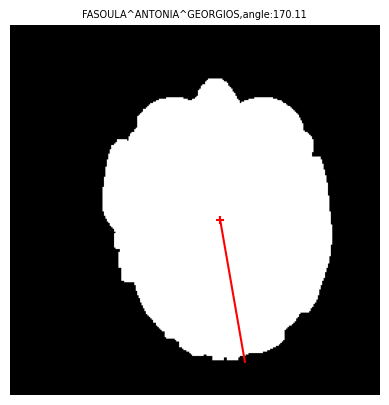

the initial angle is:  170.10578169142966
procceding rotation... >90 degrees
angle in perpenticular plane: -9.894218308570345
patient's name:FASOULA^ANTONIA^GEORGIOS,patient's sex:F,patients'age:56,Glasgow Coma Scale:NA


 33%|███▎      | 1/3 [00:18<00:37, 18.76s/it]

the type of scan is: head
The actual shape of the scan is: (164, 512, 512)


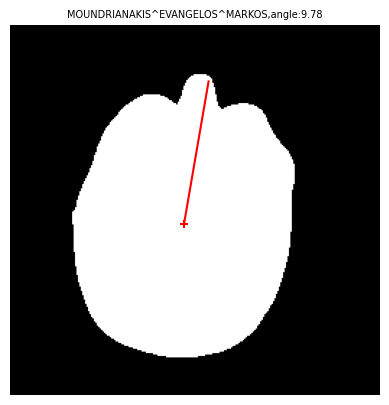

 67%|██████▋   | 2/3 [01:04<00:34, 34.63s/it]

the initial angle is:  9.777843926256622
patient's name:MOUNDRIANAKIS^EVANGELOS^MARKOS,patient's sex:M,patients'age:47,Glasgow Coma Scale:4
----------------------------------------------------------------------------------------------------
the type of scan is: RoutineSeq  1.5  H30s
The actual shape of the scan is: (120, 512, 512)


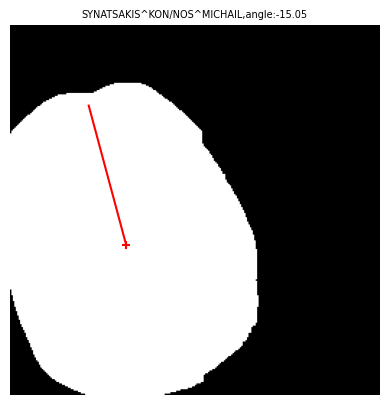

the initial angle is:  -15.046200519164302
procceding rotation... <-14 degrees
angle in perpenticular plane: -15.046200519164302
patient's name:SYNATSAKIS^KON/NOS^MICHAIL,patient's sex:M,patients'age:24,Glasgow Coma Scale:15


100%|██████████| 3/3 [01:29<00:00, 29.95s/it]


(3,)

In [1]:
import pydicom as dcm
import os
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from segment_brain import segment
from tqdm import tqdm
import re
from CT_DATASET_module import *

PATH_WITH_ALL_SCANS = r'C:\Theodoropoulos\Code\EXCEL PAGNI DEDOMENA\CT-scan-preprocessing\ALL SCANS' 
desired_volume_dims_after_resampling = (120,256,256)
THRESHOLD = 20
all_patients =CT_DATASET(PATH_WITH_ALL_SCANS,desired_volume_dims_after_resampling)

patients = []
for patient in tqdm(os.listdir(PATH_WITH_ALL_SCANS)[:4]):  
# for patient in tqdm(os.listdir(PATH_WITH_ALL_SCANS)):    
        # for folder in os.listdir(os.path.join(PATH_WITH_ALL_SCANS,patient)):
            patients.append(all_patients.process_scan(os.path.join(PATH_WITH_ALL_SCANS,patient),patient))

patients = np.array(patients)
patients.shape

In [2]:
X = np.array([patients[i]['volume']  for i in range(len(patients)) ])
X =np.transpose(X,(0,2,3,1))
print(X.shape)
y = np.array([np.random.randint(0, 2) for _ in range(X.shape[0])])[...,np.newaxis]
print(y.shape)

(3, 256, 256, 120)
(3, 1)


8.369173129203554e-31

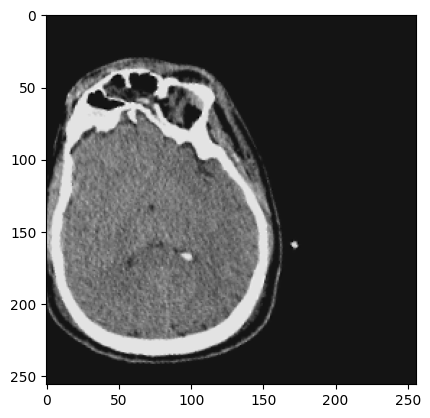

In [3]:
plt.imshow(X[2][:,:,65],cmap='gray')
X[2][:,:,65][200,200]

In [4]:
from sklearn.preprocessing import LabelEncoder

labels_sex = np.array([patients[i]['sex']  for i in range(len(patients)) ])
le = LabelEncoder()
le.fit(labels_sex)
labels_sex_transf = le.transform(labels_sex)
labels_sex_transf, labels_sex

(array([0, 1, 1]), array(['F', 'M', 'M'], dtype='<U1'))

In [5]:
from sklearn.preprocessing import LabelEncoder

labels_age = np.array([patients[i]['age']  for i in range(len(patients)) ])
labels_age_categ = []
for age in labels_age:
    if age=='NA':
        labels_age_categ.append('NA')
    elif int(age)<30:
        labels_age_categ.append('Adult')
    elif int(age)>=30 and int(age)<60:
        labels_age_categ.append('Middle')
    else:
        labels_age_categ.append('Old')

labels_age_categ =np.array(labels_age_categ)

le = LabelEncoder()
le.fit(labels_age_categ)
labels_age_transf = le.transform(labels_age_categ)
labels_age_transf,labels_age_categ


(array([1, 1, 0]), array(['Middle', 'Middle', 'Adult'], dtype='<U6'))

In [6]:
labels_GCS = np.array([patients[i]['Glasgow Coma Scale']  for i in range(len(patients)) ])
labels_GCS_categ = []
for GCS in labels_GCS:
    if GCS=='NA':
        labels_GCS_categ.append('NA')
    elif int(GCS)<=8:
        labels_GCS_categ.append('HIGH')
    else:
        labels_GCS_categ.append('LOW')

labels_GCS_categ =np.array(labels_GCS_categ)

le = LabelEncoder()
le.fit(labels_GCS_categ)
labels_GCS_transf = le.transform(labels_GCS_categ)
labels_GCS_transf,labels_GCS_categ

(array([2, 0, 1]), array(['NA', 'HIGH', 'LOW'], dtype='<U4'))

In [7]:
from sklearn.model_selection import train_test_split
X_train,  X_test,  y_train, y_test,   labels_sex_train, labels_sex_test,  labels_age_train, labels_age_test ,label_GCS_train, label_GCS_test= train_test_split( X, y,
                                                                                                                                                                labels_sex_transf,
                                                                                                                                                                labels_age_transf,
                                                                                                                                                                labels_GCS_transf,
                                                                                                                                                                test_size=0.2)

In [8]:
from My_model import MultipleInputsModel


model =MultipleInputsModel(input_shape=(256,256,120),sex_label_shape=(1,),age_label_shape=(1,),GCS_label_shape=(1,),
                           age_num_classes=len(np.unique(labels_age_transf)),
                           sex_num_classes=len(np.unique(labels_sex_transf)),
                           GCS_num_classes=len(np.unique(labels_GCS_transf)),
                           )
# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)


In [9]:
import random
import tensorflow as tf


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], 'float64')
    return augmented_volume

def train_preprocessing(volume, labels_sex,labels_age,labels_gcs,y):
# def train_preprocessing(volume,y):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    
    # volume = tf.expand_dims(volume, axis=3)
    print(volume.dtype)
    return (volume, labels_sex,labels_age,labels_gcs),y
    # return volume,y

def test_preprocessing(volume, labels_sex,labels_age,labels_gcs,y):
# def test_preprocessing(volume,y):

    # volume = tf.expand_dims(volume, axis=3)
    return (volume, labels_sex,labels_age,labels_gcs),y
    # return volume,y

dataset = tf.data.Dataset.from_tensor_slices(({"input_1": sent1, "input_2": sent2}, labels))

In [10]:
import tensorflow as tf 

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train,    
                                                     labels_sex_train, 
                                                     labels_age_train, 
                                                     label_GCS_train, 
                                                     y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test,    
                                                     labels_sex_test, 
                                                     labels_age_test, 
                                                     label_GCS_test, 
                                                     y_test))



# for volume,sex,age,gcs,label in train_loader:
#     print(volume.shape)

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)




<dtype: 'float64'>


In [13]:
epochs = 5
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    # callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5


2/2 - 8s - loss: 4.4938e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 8s/epoch - 4s/step
Epoch 2/5
2/2 - 7s - loss: 4.8303e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 7s/epoch - 4s/step
Epoch 3/5
2/2 - 7s - loss: 8.8138e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 7s/epoch - 3s/step
Epoch 4/5
2/2 - 6s - loss: 4.6868e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 6s/epoch - 3s/step
Epoch 5/5
2/2 - 6s - loss: 4.3879e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 6s/epoch - 3s/step


https://stackoverflow.com/questions/52582275/tf-data-with-multiple-inputs-outputs-in-keras

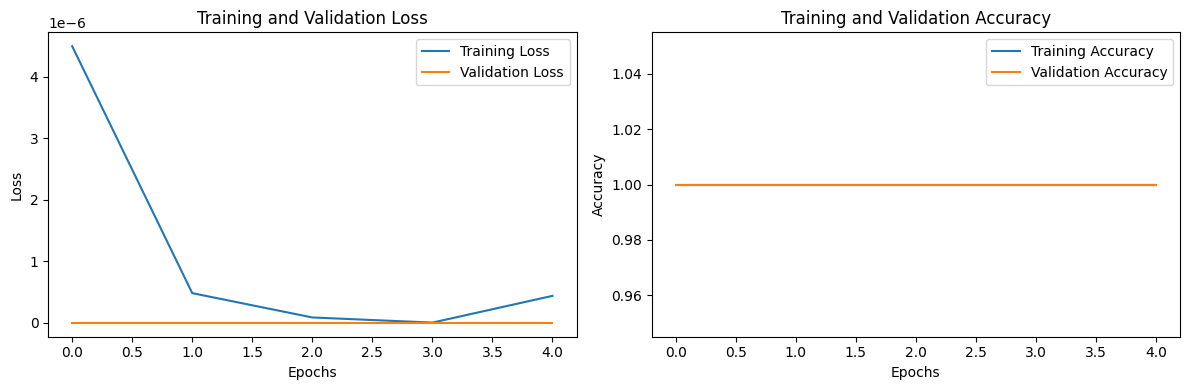

In [14]:
import matplotlib.pyplot as plt


# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:


import plotly.graph_objects as go
import plotly.express as px



# Create a Plotly figure for loss
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['loss'],
                             mode='lines',
                             name='Training Loss',
                             line=dict(color='blue')))
fig_loss.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['val_loss'],
                             mode='lines',
                             name='Validation Loss',
                             line=dict(color='orange')))

fig_loss.update_layout(title='Training and Validation Loss',
                      xaxis_title='Epochs',
                      yaxis_title='Loss',
                      template='plotly_dark')

# Create a Plotly figure for accuracy
fig_accuracy = go.Figure()

fig_accuracy.add_trace(go.Scatter(x=history.epoch,
                                 y=history.history['accuracy'],
                                 mode='lines',
                                 name='Training Accuracy',
                                 line=dict(color='green')))
fig_accuracy.add_trace(go.Scatter(x=history.epoch,
                                 y=history.history['val_accuracy'],
                                 mode='lines',
                                 name='Validation Accuracy',
                                 line=dict(color='red')))

fig_accuracy.update_layout(title='Training and Validation Accuracy',
                          xaxis_title='Epochs',
                          yaxis_title='Accuracy',
                          template='plotly_dark')

# Show the figures
fig_loss.show()
fig_accuracy.show()



In [16]:
model.predict([X_test,labels_sex_test,labels_age_test,label_GCS_test] )

1/1 [==============================] - 0s 253ms/step


array([[0.]], dtype=float32)

In [17]:
model.predict([np.expand_dims(X_test[0],axis=0) ,   np.array([labels_sex_test[0]]),  np.array([labels_sex_test[0]]) ,np.array([label_GCS_test[0]])  ] )

1/1 [==============================] - 0s 211ms/step


array([[0.]], dtype=float32)

In [ ]:
#δεν παιζει τα labels

import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming you have a single image file path, sex label, and age label
image_path = 'PATH_TO_IMAGE'
sex_label = 'Male'  # or 'Female'
age_label = 'Middle'  # or any appropriate age label

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Assuming you normalized your images during training

# Encode sex label
sex_encoded = le.transform([sex_label])

# Encode age label
age_encoded = np.array([age_label])

# Make the prediction
prediction = model.predict([np.expand_dims(X_test[0],axis=0), sex_encoded, age_encoded])

# Convert the prediction to a binary class (0 or 1)
binary_prediction = 1 if prediction > 0.5 else 0

print("Predicted Probability:", prediction)
print("Predicted Class:", binary_prediction)